# CRTC Hearing Text Analysis

The purpose of this notebook is to illustrate the method of text analysis using a corpus created from digital content published by the CRTC. This is the second part in a two-part process, the first of which is a description of the code that 'scraped' the CRTC webpage to create the corpus. 

----

The code below imports the modules that are required to process the text. 

In [1]:
# importing code modules
import json
import ijson
from ijson import items

import pprint
from tabulate import tabulate

import matplotlib.pyplot as plt

import re
import csv
import sys
import codecs

import nltk
import nltk.collocations
import collections
import statistics
from nltk.metrics.spearman import *
from nltk.collocations import *
from nltk.stem import WordNetLemmatizer


# This is a function for reading the contents of files
def read_file(filename):
    "Read the contents of FILENAME and return as a string."
    infile = codecs.open(filename, 'r', 'utf-8')
    contents = infile.read()
    infile.close()
    return contents

This code loads and then reads the necessary files: the `json` file with all the hearing text, and a `txt` file with a list of stopwords, taken from here: http://www.lextek.com/manuals/onix/stopwords2.html. I've also added a few custom words.

In [2]:
# loading the JSON file
filename = "../scrapy/hearing_result6.json"

# loading the stopwords file
stopwords = read_file('cornellStopWords.txt')
customStopwords = stopwords.split()

In [3]:
# reads the file and assigns the keys and values to a Python dictionary structure
with open(filename, 'r') as f:
    objects = ijson.items(f, 'item')
    file = list(objects)

A bit of error checking here to confirm the number of records in the file. We should have 14.

In [4]:
# checks to see how many records we have
print(len(file))

14


Changing the number in the code below will print a different record from the file. Please remember that in coding, numbered lists begin at `0`.

In [5]:
# prints all content in a single record. Changing the number shows a different record
file[5]

{'dateIssued': '2016-04-18',
 'docType': 'Transcripts',
 'subject': 'Transcripts, Public hearings',
 'text': ['Transcript, Hearing April 18, 2016',
  'Volume: 6 ',
  '\r\nLocation: Gatineau, Quebec',
  '\r\nDate: April 18, 2016',
  '\r\n© Copyright Reserved',
  'Attendees and Location',
  'Held at:',
  'Outaouais Room',
  '\r\nConference Centre',
  '\r\n140 Promenade du Portage',
  '\r\nGatineau, Québec',
  'Attendees:',
  'Chairman: Jean-Pierre Blais',
  'Members: Candice Molnar, Peter Menzies, Linda Vennard, Christopher MacDonald',
  'Legal Counsel: Emilia de Somma, Amy Hamley',
  'Secretary: Jade Roy',
  'Hearing Managers',
  ':\r\nJohn Macri, Christine Bailey, Sarah O’Brian',
  'Transcript',
  'Gatineau, Québec',
  '--- Upon resuming on Monday, April 18, 2016 at 9:03 a.m.',
  '6945 So those of you in the room, it will be abundantly clear that we will be doing a lot of interpretation today, but those listening that are from a distance may not have noticed.',
  "6946 So I will -- tha

Here is a bit more error checking to confirm the record titles and their urls.

In [6]:
# iterates through each record in the file
for row in file:
    # prints the title of each record and its url
    print(row['title'], ":", row['url'])

Transcript, Hearing April 11, 2016  : http://www.crtc.gc.ca/eng/transcripts/2016/tt0411.htm
Transcript, Hearing April 12, 2016  : http://www.crtc.gc.ca/eng/transcripts/2016/tt0412.htm
Transcript, Hearing April 13, 2016  : http://www.crtc.gc.ca/eng/transcripts/2016/tt0413.htm
Transcript, Hearing April 14, 2016  : http://www.crtc.gc.ca/eng/transcripts/2016/tt0414.htm
Transcript, Hearing April 15, 2016  : http://www.crtc.gc.ca/eng/transcripts/2016/tt0415.htm
Transcript, Hearing April 18, 2016  : http://www.crtc.gc.ca/eng/transcripts/2016/tt0418.htm
Transcript, Hearing April 19, 2016  : http://www.crtc.gc.ca/eng/transcripts/2016/tt0419.htm
Transcript, Hearing April 20, 2016  : http://www.crtc.gc.ca/eng/transcripts/2016/tt0420.htm
Transcript, Hearing April 21, 2016  : http://www.crtc.gc.ca/eng/transcripts/2016/tt0421.htm
Transcript, Hearing April 22, 2016  : http://www.crtc.gc.ca/eng/transcripts/2016/tt0422.htm
Transcript, Hearing April 25, 2016  : http://www.crtc.gc.ca/eng/transcripts/2016

And a bit more processing to make the text more readable. It's printed below.

In [7]:
# appends all of the text items to a single string object (rather than a list)
joined_text = []
for row in file:
    joined_text.append(' '.join(row['text']))

In [8]:
# shows the text. Changing the number displays a different record
print(joined_text[5])

Transcript, Hearing April 18, 2016 Volume: 6  
Location: Gatineau, Quebec 
Date: April 18, 2016 
© Copyright Reserved Attendees and Location Held at: Outaouais Room 
Conference Centre 
140 Promenade du Portage 
Gatineau, Québec Attendees: Chairman: Jean-Pierre Blais Members: Candice Molnar, Peter Menzies, Linda Vennard, Christopher MacDonald Legal Counsel: Emilia de Somma, Amy Hamley Secretary: Jade Roy Hearing Managers :
John Macri, Christine Bailey, Sarah O’Brian Transcript Gatineau, Québec --- Upon resuming on Monday, April 18, 2016 at 9:03 a.m. 6945 So those of you in the room, it will be abundantly clear that we will be doing a lot of interpretation today, but those listening that are from a distance may not have noticed. 6946 So I will -- that's why I'm explaining it to you that although we normally operate with French and English interpretation, this morning we will be on top of that also working interpretation through ASL and LSQ. 6947 As a consequence, we will try and others i

This is the begining of the first processing for the text analysis. Here we will split all the words apart, make them all lowercase, and remove the punctuation, numbers, and words on the stopword list.

In [9]:
# splits the text string in each record into a list of separate words
token_joined = []
for words in joined_text:
    # splits the text into a list of words
    text = words.split()
    # makes all words lowercase
    clean = [w.lower() for w in text if w.isalpha()]
    # applies stopword removal
    text = [w for w in clean if w not in customStopwords]
    token_joined.append(text)

Since a word of interest is `guarantee`, here is a list of how many times that word (and its variations) appear in each record. 

In [10]:
for title,word in zip(file,token_joined):
    print(title['title'],"guarantee:", word.count('guarantee'), "guarantees:", \
          word.count('guarantees'), "guaranteed:", word.count('guaranteed'))

Transcript, Hearing April 11, 2016  guarantee: 1 guarantees: 0 guaranteed: 1
Transcript, Hearing April 12, 2016  guarantee: 2 guarantees: 3 guaranteed: 0
Transcript, Hearing April 13, 2016  guarantee: 0 guarantees: 2 guaranteed: 0
Transcript, Hearing April 14, 2016  guarantee: 0 guarantees: 0 guaranteed: 0
Transcript, Hearing April 15, 2016  guarantee: 1 guarantees: 1 guaranteed: 1
Transcript, Hearing April 18, 2016  guarantee: 4 guarantees: 11 guaranteed: 2
Transcript, Hearing April 19, 2016  guarantee: 0 guarantees: 0 guaranteed: 0
Transcript, Hearing April 20, 2016  guarantee: 0 guarantees: 0 guaranteed: 0
Transcript, Hearing April 21, 2016  guarantee: 2 guarantees: 0 guaranteed: 0
Transcript, Hearing April 22, 2016  guarantee: 1 guarantees: 0 guaranteed: 0
Transcript, Hearing April 25, 2016  guarantee: 0 guarantees: 1 guaranteed: 0
Transcript, Hearing April 26, 2016  guarantee: 0 guarantees: 0 guaranteed: 0
Transcript, Hearing April 27, 2016  guarantee: 1 guarantees: 0 guaranteed: 

It looks like record number 5 has the most occurences of the word `guarantee`. The code below isolates the record and creates a concordance based on the selected word.

In [11]:
# splits the text from the record into a list of individual words
words = joined_text[5].split()
#assigns NLTK functionality to the text
text = nltk.Text(words)

In [12]:
# prints a concordance output for the selected word (shown in green)
print(text.concordance('guarantees', lines=25))

Displaying 11 of 11 matches:
age that includes minimum service guarantees at a reasonable price. 7230 Canad
ckage that offers service quality guarantees to end users whose particular nee
ot demand minimum service quality guarantees or symmetric speeds on fixed and 
ire minimum basic service quality guarantees for their reliable and safe utili
 includes minimum service quality guarantees and meets the minimum service sta
o deliver minimum service quality guarantees to end users. 7241 Most of the la
nical capacity of delivering such guarantees and, in fact, many do so on deman
argue that they do not offer such guarantees to individuals and small-and-medi
for service packages that include guarantees of minimum service quality operat
t include minimum service quality guarantees would not only be critical for th
 taxes. So the quality of service guarantees and the disabilities rights offic
None


Below is what the text looks like after the initial processing, without punctuation, numbers, or stopwords.

In [13]:
# shows the text list for a given record. Changing the number displays a different record
print(token_joined[5])

['hearing', 'april', 'quebec', 'april', 'copyright', 'reserved', 'attendees', 'location', 'held', 'outaouais', 'room', 'conference', 'centre', 'promenade', 'du', 'portage', 'québec', 'blais', 'candice', 'peter', 'linda', 'christopher', 'macdonald', 'legal', 'emilia', 'de', 'amy', 'hamley', 'jade', 'roy', 'hearing', 'managers', 'john', 'christine', 'sarah', 'transcript', 'québec', 'resuming', 'april', 'abundantly', 'clear', 'lot', 'interpretation', 'listening', 'distance', 'explaining', 'operate', 'french', 'english', 'morning', 'top', 'working', 'interpretation', 'asl', 'room', 'endeavour', 'pace', 'lost', 'madame', 'la', 'la', 'hear', 'presentation', 'deaf', 'wireless', 'canada', 'committee', 'hear', 'presentation', 'canadian', 'association', 'introduce', 'colleagues', 'minutes', 'presentation', 'good', 'madam', 'good', 'commissioners', 'present', 'lisa', 'deaf', 'wireless', 'canada', 'left', 'arista', 'haas', 'nicole', 'marsh', 'nicole', 'rytch', 'frank', 'president', 'canadian', 'as

Here is a count of the number of words in each record. While this data isn't terribly useful 'as is', we can make a few assumptions about the text here. Notably that some of the hearings were much longer than others.

In [14]:
# counting the number of words in each record 
for name, each in zip(file,token_joined):
    print(name['title'], ":",len(each), "words")

Transcript, Hearing April 11, 2016  : 16664 words
Transcript, Hearing April 12, 2016  : 12891 words
Transcript, Hearing April 13, 2016  : 8423 words
Transcript, Hearing April 14, 2016  : 8319 words
Transcript, Hearing April 15, 2016  : 4840 words
Transcript, Hearing April 18, 2016  : 13523 words
Transcript, Hearing April 19, 2016  : 10184 words
Transcript, Hearing April 20, 2016  : 8541 words
Transcript, Hearing April 21, 2016  : 12865 words
Transcript, Hearing April 22, 2016  : 3400 words
Transcript, Hearing April 25, 2016  : 14791 words
Transcript, Hearing April 26, 2016  : 11804 words
Transcript, Hearing April 27, 2016  : 7454 words
Transcript, Hearing April 28, 2016  : 6803 words


Here is some more processing to count the occurences of words in the records as a whole.

In [15]:
# counts the occurence of each word in the file
for each in token_joined:
    wordcounts = dict([ [t, each.count(t)] for t in set(each) ])

In [16]:
# sorts the list by highest frequency
items = [(v, k) for k, v in wordcounts.items()]

In [17]:
# prints the list in a nicer format, here showing only the top 50 words
for count, word in sorted(items, reverse=True)[:50]:
    print("%5d %s" % (count, word))

   60 people
   43 broadband
   42 access
   40 make
   40 commission
   39 lot
   37 terms
   37 internet
   35 question
   35 put
   34 service
   34 data
   33 canadians
   29 government
   26 things
   26 digital
   25 time
   25 price
   25 market
   25 heard
   25 cost
   25 basic
   24 talking
   24 sort
   24 point
   23 problem
   23 number
   23 million
   23 kind
   22 transport
   22 national
   22 back
   21 providers
   21 issue
   21 important
   21 bit
   21 answer
   21 affordability
   20 services
   20 public
   20 prices
   20 good
   20 based
   19 work
   19 thing
   19 targets
   19 start
   19 role
   18 years
   18 money


Some more preparation for the text processing. The code below works on the all of the records, creating one master list of words which is then lemmatized.

In [18]:
# creates a variable for the lemmatizing function
wnl = WordNetLemmatizer()

# lemmatizes all of the verbs
lemm = []
for record in token_joined:
        for word in record:
            lemm.append(wnl.lemmatize(word, 'v'))

# lemmatizes all of the nouns 
lems = []
for word in lemm:
    lems.append(wnl.lemmatize(word, 'n'))

Here we are checking to make sure the lemmatizer has worked. Now the word `guarantee` only appears in one form.

In [19]:
# just making sure the lemmatizer has worked
print("guarantee:", lems.count('guarantee'), "guarantees:", \
          lems.count('guarantees'), "guaranteed:", lems.count('guaranteed'))

guarantee: 36 guarantees: 0 guaranteed: 0


These are the 10 most common word pairs in the text.

In [20]:
# prints the 10 most common bigrams
colText = nltk.Text(lems)
colText.collocations(10)

service provider; market force; digital literacy; basic service; data
cap; eastern ontario; fix wireless; private sector; low income; rural
remote


Error checking to make sure the code is processing the text properly.

In [21]:
# creates a list of bigrams (ngrams of 2), printing the first 5
colBigrams = list(nltk.ngrams(colText, 2)) 
colBigrams[:5]

[('hear', 'april'),
 ('april', 'quebec'),
 ('quebec', 'april'),
 ('april', 'copyright'),
 ('copyright', 'reserve')]

More error checking.

In [22]:
# error checking. There should be one less bigram than total words
print("Number of words:", len(lems))
print("Number of bigrams:", len(colBigrams))

Number of words: 140502
Number of bigrams: 140501


Below is a frequency plot showing the occurence of the 25 most frequent words.

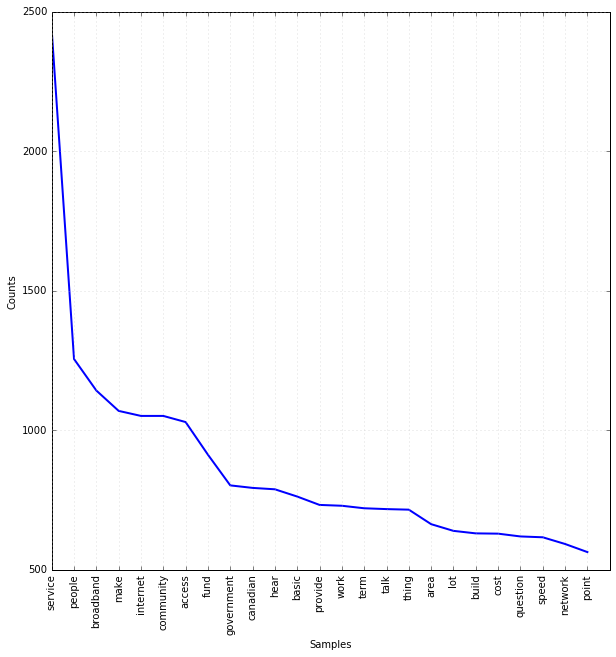

In [23]:
# frequency plot with stopwords removed
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
fd = nltk.FreqDist(colText)
fd.plot(25)

Here we are preparing the text to search for bigrams containing the word `guarantee`. This code searches for words appearing before and after `guarantee` with a window size of two words on either side.

In [24]:
# loads bigram code from NLTK
bigram_measures = nltk.collocations.BigramAssocMeasures()
# bigrams with a window size of 2 words
finder = BigramCollocationFinder.from_words(lems, window_size = 2)
# ngrams with 'word of interest' as a member
word_filter = lambda *w: 'guarantee' not in w
# only bigrams that contain the 'word of interest'
finder.apply_ngram_filter(word_filter)

In [25]:
# filter results based on statistical test

# calulates the raw frequency as an actual number and percentage of total words
act = finder.ngram_fd.items()
raw = finder.score_ngrams(bigram_measures.raw_freq)
# log-likelihood ratio
log = finder.score_ngrams(bigram_measures.likelihood_ratio)

Research shows that this is the most reliable statistical test for unreliable data. 

**Log-Likelihood Ratio**

The Log-likelihood ratio calculates the size and significance between the observed and expected frequencies of bigrams and assigns a score based on the result, taking into account the overall size of the corpus. The larger the difference between the observed and expected, the higher the score, and the more statistically significant the collocate is.
The Log-likelihood ratio is my preferred test for collocates because it does not rely on a normal distribution, and for this reason, it can account for sparse or low frequency bigrams. It does not over-represent low frequency bigrams with inflated scores, as the test is only reporting how much more likely it is that the frequencies are different than they are the same. The drawback to the Log-likelihood ratio is that it cannot be used to compare scores across corpora.

An important note here that **words will appear twice** in the following list. As the ngrams can appear both before and after the word, care must be taken to identify duplicate occurences in the list below and then combine the totals.

In [26]:
# prints list of results. 
print(tabulate(log, headers = ["Collocate", "Log-Likelihood"], floatfmt=".3f", \
               numalign="left"))

Collocate                     Log-Likelihood
----------------------------  ----------------
('quality', 'guarantee')      76.826
('guarantee', 'minimum')      29.905
('incentivize', 'guarantee')  16.567
('guarantee', 'critical')     15.615
('level', 'guarantee')        15.213
('guarantee', 'reliable')     15.003
('incapable', 'guarantee')    13.795
('guarantee', 'demand')       13.251
('embargo', 'guarantee')      12.070
('headline', 'guarantee')     11.565
('safety', 'guarantee')       9.870
('guarantee', 'symmetric')    9.522
('guarantee', 'end')          9.398
('guarantee', 'translate')    9.226
('guarantee', 'congestion')   8.969
('guarantee', 'notion')       7.620
('guarantee', 'guarantee')    7.445
('pas', 'guarantee')          6.671
('measure', 'guarantee')      6.296
('guarantee', 'board')        6.063
('guarantee', 'residential')  5.905
('size', 'guarantee')         5.880
('operator', 'guarantee')     5.782
('average', 'guarantee')      5.712
('guarantee', 'versus')       5.69

Here is an example of words appearing twice. Below are both instances of the ngram 'quality'. The first instance appears before 'guarantee' and the second occurs after.

A bit more processing to clean up the list.

In [27]:
##################################################################
############### sorts list of log-likelihood scores ##############
##################################################################

# group bigrams by first and second word in bigram                                        
prefix_keys = collections.defaultdict(list)
for key, l in log:
    # first word
    prefix_keys[key[0]].append((key[1], l))
    # second word
    prefix_keys[key[1]].append((key[0], l))
    
# sort bigrams by strongest association                                  
for key in prefix_keys:
    prefix_keys[key].sort(key = lambda x: -x[1])

    # prints top 80 results
logkeys = prefix_keys['guarantee'][:80]

Here is a list showing **only** the collocates for the word `guarantee`. Again, watch for duplicate words below.

In [28]:
from tabulate import tabulate
print(tabulate(logkeys, headers = ["Collocate", "Log-Likelihood"], floatfmt=".3f", \
               numalign="left"))

Collocate    Log-Likelihood
-----------  ----------------
quality      76.826
minimum      29.905
incentivize  16.567
critical     15.615
level        15.213
reliable     15.003
incapable    13.795
demand       13.251
embargo      12.070
headline     11.565
safety       9.870
symmetric    9.522
end          9.398
translate    9.226
congestion   8.969
notion       7.620
guarantee    7.445
guarantee    7.445
pas          6.671
measure      6.296
board        6.063
residential  5.905
size         5.880
operator     5.782
average      5.712
versus       5.690
result       5.558
incumbent    5.160
disability   5.012
service      4.836
reasonable   4.774
individual   4.408
quality      3.955
megabit      3.652
deliver      3.564
money        3.394
offer        3.343
speak        3.293
meet         3.164
include      2.977
level        2.937
market       2.878
data         2.737
year         2.414
kind         2.354
sort         2.192
speed        2.026
term         1.767
provide      1.740
p

---

In [29]:
# working on a regex to split text by speaker
#diced = re.split('(\d+(\s)\w+[A-Z](\s|.\s)\w+[A-Z]:\s)', joined)